# Exercise 3: Beyond the Ground State Again


Same as the last exercise with operators $\hat{X}^3(t)$ instead of $\hat{X}(t)$

### Potentials

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import vegas
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

#Harmonic
def v_sho(x):
    
    return (x**2)/2

#Anharmonic
def v_aho(x):
    
    return (x ** 4)/2


### Action for One Spatial Point

In [132]:
def action(x, i, v, m, a): 
    ir = (i+1)%len(x) 
    il = (i-1)%len(x)
    return a *  v(x[i]) + (m/a) * x[i] * (x[i]-x[ir]-x[il])

### Update Function

In [133]:
def update(x, v, m, a, dx):
    #Updates Every Point Once
    accept = 0
    for i in range(len(x)):
        
        x_old = x[i]
        old_action = action(x=x, i=i, v=v, m=m, a=a)
        
        x[i] += np.random.uniform(-dx, dx)
        new_action = action(x=x, i=i, v=v, m=m, a=a)
        
        diff = old_action - new_action
        
        r = np.minimum(1.0, np.exp(diff))
    
        if r < np.random.rand():
            x[i] = x_old
        
        else:
            accept += 1
    
    return x, accept / len(x)

### Two Point Function

In [134]:
def G(x):
    #Returns Array Gn = [G1, G2,...]
    n = len(x)
    g = np.zeros(n)
    for j in range(n):
        for i in range(n):
            g[j] += ((x[(i+j)%(n)])**3) * ((x[i])**3)
            
    return g/n

### Markov Chain Generation

In [135]:
def markov_chain(n_sites, n_configs, v, m, a, dx, n_corr):
    
    acc = 0
    config = np.zeros((n_sites))
    gn = []
    
    #Thermalise
    for i in range(10*n_corr):
        config = update(config, v, m, a, dx)[0]


    for i in range(n_configs*n_corr):
        config, acceptance = update(config, v, m, a, dx)
        acc += acceptance
        
        if i % n_corr == 0:
            gn.append(G(config))
            
    acc = acc / (n_configs*n_corr)
            
    return gn, acc

### Analysis

In [136]:
def analysis(n_sites, n_cfs_arr, v, m, a, dx, n_corr, harmonic=True):
    
    rows = int(np.ceil(len(n_cfs_arr)/2))
    fig, axs =  plt.subplots(nrows=rows, ncols=2, sharex='col', figsize=(8, 8), dpi=100)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    ax = axs.flat
    
    for i, n_configs in enumerate(n_cfs_arr):
    
        gn, acc = markov_chain(n_sites=n_sites, n_configs=n_configs, v=v, m=m, a=a, dx=dx, n_corr=n_corr)
    
        avg = np.mean(gn,0)
        err = np.std(gn,0) / np.sqrt(n_configs)
        avg_shift = np.roll(avg, -1)
        err_shift = np.roll(err, -1)
        
        E_eff = np.log(np.divide(avg,avg_shift)) / a
        E_eff_err = np.sqrt(np.divide(err, avg)**2 + np.divide(err_shift, avg_shift)**2)/ a / np.sqrt(n_configs)
    
    
        t = np.arange(0, n_sites * a, a)
    
        
        
        ax[i].set_ylim(0, 2)
        ax[i].errorbar(t, E_eff, yerr=err, fmt='o',  markersize=2, color='k')
        ax[i].tick_params(bottom="off", top="off", left="off", right="off")
        ax[i].set_title("Effective Energy for N_configs: " + str(n_configs))
        ax[i].set_xlim(0, 10)
        ax[i].set_xticks([0, 2, 4, 6, 8, 10])
        ax[i].set_ylim(-2, 2)
        ax[i].set_yticks([-2, -1, 0, 1, 2])
        if harmonic == True:
            ax[i].axhline(y=1, color='r', linestyle='-')
        
            
            
        
    
    print("Acceptance Rate: " + str(acc))
    plt.show()

### Results for Harmonic Oscillator

Acceptance Rate: 0.49636047499998004


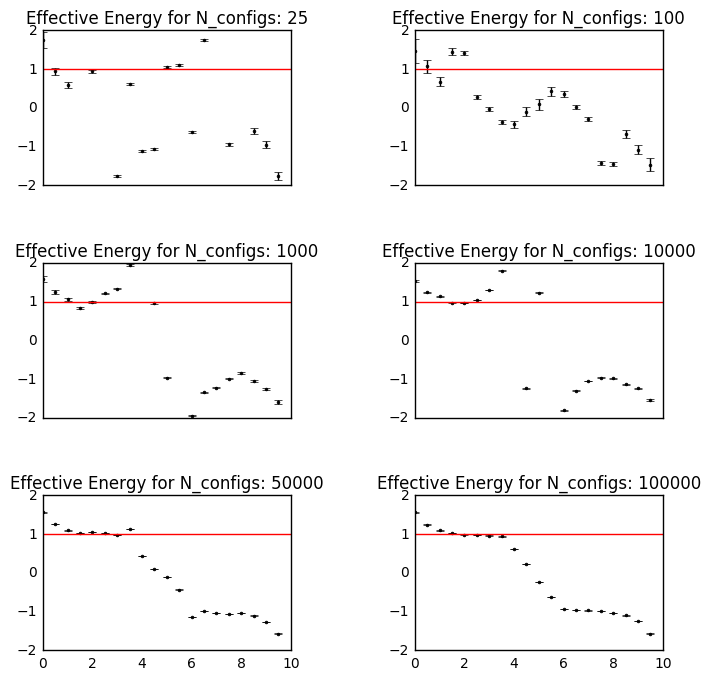

In [137]:
analysis(n_sites=20, n_cfs_arr=[25,100,1000,10000,50000,100000], v=v_sho, m=1, a=0.5, dx=1.4, n_corr=20)

Takes longer to converge to asymptotic value. Approach from above is obvious here.

### Results for Anharmonic Oscillator

Acceptance Rate: 0.4842940999999325


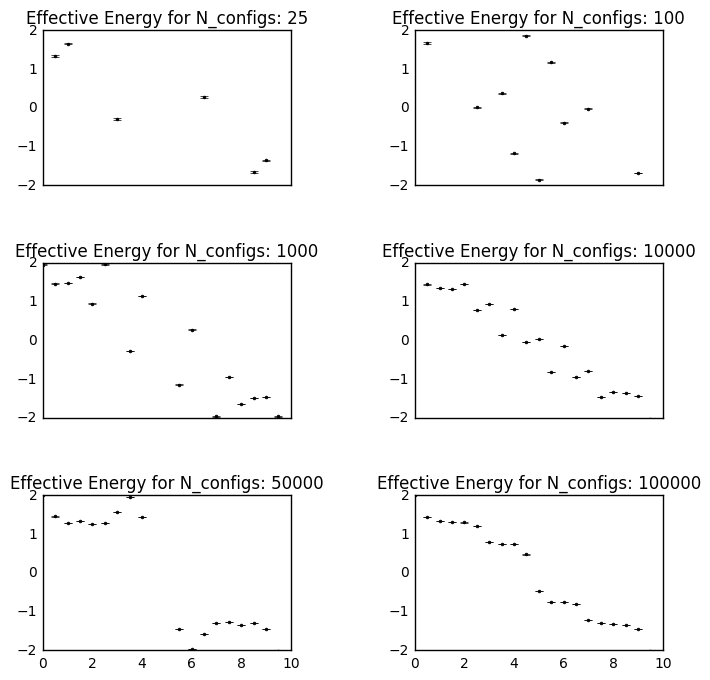

In [138]:
analysis(n_sites=20, n_cfs_arr=[25, 100, 1000, 10000,50000,100000], v=v_aho, m=1, a=0.5, dx=1.4, n_corr=20, harmonic=False)

### Proof that the Effective Energy Approaches from Above.

The goal is to show that

\begin{eqnarray*}
\log\left(\frac{G(t)}{G(t+a)}\right)
\end{eqnarray*}

is a monotonically decreasing function of $t = t_2 - t_1$, where

\begin{eqnarray*}
G(t) = \lim_{T \to \infty} \big\langle \hat{O}(t_2)\hat{O}(t_1)\big\rangle
\end{eqnarray*}

The simplest way is to show the derivative of this function is always less than zero. Rewriting

\begin{eqnarray*}
\log\left(\frac{G(t)}{G(t+a)}\right) &=& \log\left(\frac{\sum_{m=0}^{\infty} \big|\big\langle 0 \big| \hat{O} \big| m \big\rangle\big|^2 e^{-t\Delta E_m}}{\sum_{m=0}^{\infty} \big|\big\langle 0 \big| \hat{O} \big| m \big\rangle\big|^2 e^{-(t+a)\Delta E_m}}\right)\\
&=& \log\left( \frac{\big|\big\langle 0 \big| \hat{O} \big| 0 \big\rangle\big|^2 e^{-t\Delta E_0} + \big|\big\langle 0 \big| \hat{O} \big| 1 \big\rangle\big|^2 e^{-t\Delta E_1} + \sum_{m=2}^{\infty} \big|\big\langle 0 \big| \hat{O} \big| m \big\rangle\big|^2 e^{-t\Delta E_m}}{\big|\big\langle 0 \big| \hat{O} \big| 0 \big\rangle\big|^2 e^{-(t+a)\Delta E_0} + \big|\big\langle 0 \big| \hat{O} \big| 1 \big\rangle\big|^2 e^{-(t+a)\Delta E_1} + \sum_{m=2}^{\infty} \big|\big\langle 0 \big| \hat{O} \big| m \big\rangle\big|^2 e^{-(t+a)\Delta E_m}}\right)\\
&=& \log\left( \frac{\big|\big\langle 0 \big| \hat{O} \big| 0 \big\rangle\big|^2 + \big|\big\langle 0 \big| \hat{O} \big| 1 \big\rangle\big|^2 e^{-t\Delta E_1}}{\big|\big\langle 0 \big| \hat{O} \big| 0 \big\rangle\big|^2  + \big|\big\langle 0 \big| \hat{O} \big| 1 \big\rangle\big|^2 e^{-(t+a)\Delta E_1}}\right)\\
\end{eqnarray*}

where the remainder of the sum is dropped as the first two terms effectively dominate


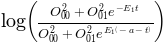

In [139]:
import sympy as sp
from sympy import init_printing, oo
init_printing(use_latex = True)

a, E_1, t, O_0, O_1 = sp.symbols('a, E_1, t, O_{00}, O_{01}')

g = O_0**2 + O_1**2 * sp.exp(-t * E_1)

g_shift = O_0**2 + O_1**2 * sp.exp(-(t+a) * E_1)

func = sp.log(g/g_shift)

func

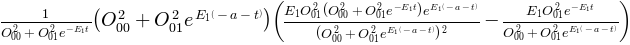

In [140]:
func.diff(t)

As all terms are greater than zero, showing this is always less than zero amounts to showing

\begin{eqnarray*}
 \frac{E_{1} O_{1}^{2} \left(O_{0}^{2} + O_{1}^{2} e^{- E_{1} t}\right) e^{E_{1} \left(- a - t\right)}}{\left(O_{0}^{2} + O_{1}^{2} e^{E_{1} \left(- a - t\right)}\right)^{2}} - \frac{E_{1} O_{1}^{2} e^{- E_{1} t}}{O_{0}^{2} + O_{1}^{2} e^{E_{1} \left(- a - t\right)}} < 0 \\
\frac{\left(O_{0}^{2} + O_{1}^{2} e^{- E_{1} t}\right) e^{-E_{1}a}}{O_{0}^{2} + O_{1}^{2} e^{E_{1} \left(- a - t\right)}} < 1 \\
O_{0}^{2}e^{-aE_{1}} + O_{1}^{2} e^{- E_{1} (t+a) } < O_{0}^{2} + O_{1}^{2} e^{-E_{1} \left(a + t\right)} \\
e^{-aE_{1}} < 1
\end{eqnarray*}

Which is true.